**Creating a random ansatz**

In [627]:
import pennylane as qml
from pennylane import numpy as np

In [628]:
N = 3
wires = range(N)
dev = qml.device("default.qubit", wires=wires)

In [629]:
@qml.qnode(dev)
def state_preparation(x):
    qml.AngleEmbedding(x, wires)
    return [qml.expval(qml.PauliZ(w)) for w in wires]

In [630]:
def layer(layer_weights):
    for wire in range(N):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in range(N - 1):
        qml.CNOT([wires, (wires + 1) % N ])

    for wire in range(N):
        qml.Rot(*layer_weights[wire], wires=wire)

In [631]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [632]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [633]:
"""def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)"""

'def square_loss(labels, predictions):\n    # We use a call to qml.math.stack to allow subtracting the arrays directly\n    return np.mean((labels - qml.math.stack(predictions)) ** 2)'

In [634]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 0.5 for l, p in zip(labels, predictions))
    acc = acc / len(predictions)
    return acc

In [635]:
"""def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)"""

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def cost(weights, bias, X, Y):
    loss = 0
    for x, y in zip(X, Y):
        pred = variational_classifier(weights, bias, x)
        prob = sigmoid(pred)
        # Map Y from (-1,1) to (0,1) for cross-entropy
        y_binary = (y + 1) / 2
        # Binary cross entropy loss
        loss -= y_binary * np.log(prob + 1e-8) + (1 - y_binary) * np.log(1 - prob + 1e-8)
    return loss / len(X)


In [636]:
def cost(weights, bias, X, Y):
    predictions = np.array([variational_classifier(weights, bias, x) for x in X])
    lam = 0.1
    return np.mean(np.inner(Y - predictions, Y - predictions)) + lam * np.mean((predictions + 1)/2 * (1 - (predictions + 1)/2))

In [637]:
n_samples = 50
X = np.column_stack((
    np.random.normal(34, 2, n_samples), # first feature
    np.random.normal(4, 1, n_samples), # Second feature
    np.random.normal(0, 2, n_samples), # Third feature
))

# Define binary variable Y as a function of X
logits = 3 * X[:, 0] - 2 * X[:, 1] + 0.5 * X[:, 2]
logits = logits - logits.mean()
Y = (logits > logits.mean()).astype(int)      # Threshold at 0.5
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}


# Normal Scaling
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))


In [638]:
for k, (x, y) in enumerate(zip(X, Y)):
  if k <= 10:
      print(f"x = {x}, y = {y}")

x = [0.98139105 0.72396099 0.50201185], y = 1
x = [0.11328182 0.71164741 0.42999741], y = -1
x = [0.89521615 0.36205615 0.28281389], y = 1
x = [0.61934593 0.4392517  0.24730372], y = 1
x = [0.91657632 0.05409868 0.34512775], y = 1
x = [0.60570963 0.2778438  0.        ], y = 1
x = [0.478043   0.7842325  0.29191351], y = -1
x = [0.66237362 0.54331334 0.54406153], y = 1
x = [0.42745702 0.95091384 0.5283534 ], y = -1
x = [0.78421833 0.60578209 0.3123449 ], y = 1
x = [0.75302011 0.33659343 0.42579342], y = 1


In [639]:
# Separete in test and train data
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [640]:
np.random.seed(0)
num_qubits = 3
num_layers = 4
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]]

 [[ 0.00410599  0.00144044  0.01454274]
  [ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]]

 [[ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]
  [ 0.02269755 -0.01454366  0.00045759]]

 [[-0.00187184  0.01532779  0.01469359]
  [ 0.00154947  0.00378163 -0.00887786]
  [-0.01980796 -0.00347912  0.00156349]]]
Bias:  0.0


Iter:    1 | Cost: 56.8100228 | Accuracy: 0.6000000
Iter:    2 | Cost: 53.8583038 | Accuracy: 0.6000000
Iter:    3 | Cost: 50.8257813 | Accuracy: 0.6000000
Iter:    4 | Cost: 47.5329747 | Accuracy: 0.6000000
Iter:    5 | Cost: 44.4293087 | Accuracy: 0.6000000
Iter:    6 | Cost: 42.8268098 | Accuracy: 0.6000000
Iter:    7 | Cost: 41.8818459 | Accuracy: 0.6000000
Iter:    8 | Cost: 41.5755940 | Accuracy: 0.4750000
Iter:    9 | Cost: 40.8085415 | Accuracy: 0.4250000
Iter:   10 | Cost: 40.5350611 | Accuracy: 0.5000000
Iter:   11 | Cost: 41.0843263 | Accuracy: 0.4000000
Iter:   12 | Cost: 42.1781800 | Accuracy: 0.4000000
Iter:   13 | Cost: 41.6747025 | Accuracy: 0.4000000
Iter:   14 | Cost: 38.6007714 | Accuracy: 0.4000000
Iter:   15 | Cost: 35.4040636 | Accuracy: 0.6750000
Iter:   16 | Cost: 33.9849712 | Accuracy: 0.7500000
Iter:   17 | Cost: 34.6756084 | Accuracy: 0.6250000
Iter:   18 | Cost: 35.4287839 | Accuracy: 0.6000000
Iter:   19 | Cost: 35.3234028 | Accuracy: 0.6000000
Iter:   20 |

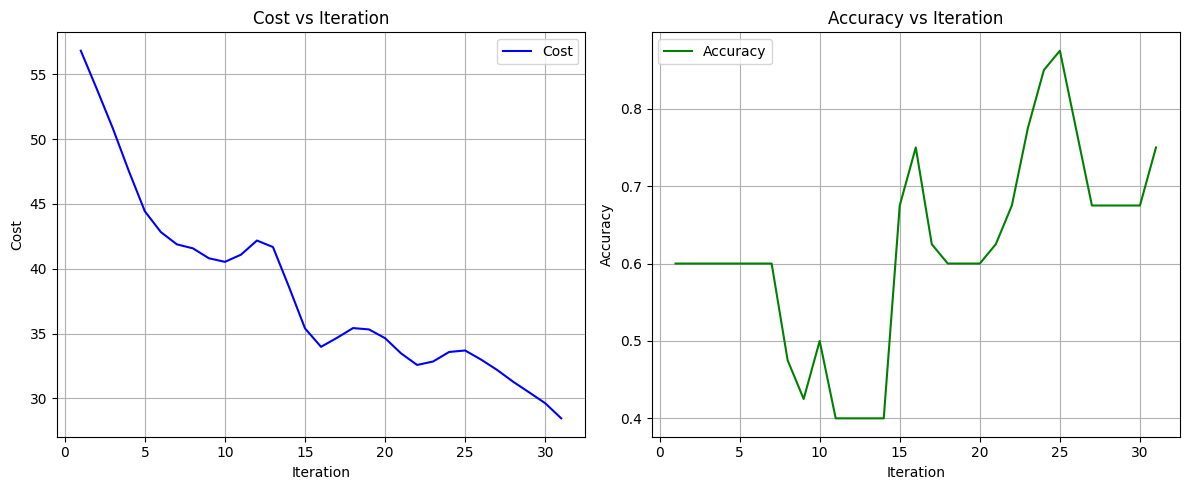

In [641]:
import matplotlib.pyplot as plt

opt = qml.AdamOptimizer(stepsize=0.05, beta1=0.9, beta2=0.9, eps=1e-08)
batch_size = 15
weights = weights_init
bias = bias_init

cost_list = []
acc_list = []
iters = []
n = 100

for it in range(n):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_train]

    current_cost = cost(weights, bias, X_train, Y_train)
    acc = accuracy(Y_train, predictions)

    if acc >= 0.9:
        break

    cost_list.append(current_cost)
    acc_list.append(acc)
    iters.append(it+1)

    
    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

# Now plot
plt.figure(figsize=(12,5))

# Plot cost
plt.subplot(1, 2, 1)
plt.plot(iters, cost_list, label="Cost", color="blue")
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs Iteration')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(iters, acc_list, label="Accuracy", color="green")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iteration')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [642]:
predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_train]

In [643]:
print(weights)

[[[-0.28320761  0.85018839 -0.21425434]
  [-0.05850213  0.06221572 -0.01950836]
  [-0.48740614 -1.1494871  -0.38799308]]

 [[-0.19165545 -0.65900229 -0.00946579]
  [-0.07153766  0.11660744 -0.09152277]
  [ 0.33297632  0.34920208  0.3478387 ]]

 [[ 0.32253324 -0.53666754  0.30663944]
  [ 0.57969558 -0.81011629  0.50548613]
  [ 0.24752465 -0.03153662  0.23325851]]

 [[ 0.39911699  0.58979206  0.55018036]
  [ 0.42531537 -0.56585221  0.4155631 ]
  [-0.01980798 -0.0034791   0.00156347]]]


In [644]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(Y_train, predictions))

Classification Report:
              precision    recall  f1-score   support

        -1.0       1.00      0.75      0.86        16
        -1.0       1.00      0.75      0.86        16
         1.0       0.86      1.00      0.92        24
         1.0       0.86      1.00      0.92        24

    accuracy                           0.90        80
   macro avg       0.93      0.88      0.89        80
weighted avg       0.91      0.90      0.90        80



In [645]:
"""data = np.loadtxt("parity_test.txt", dtype=float)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}"""

from sklearn.datasets import make_classification
import numpy as np

predictions_test = [1/(1 + np.exp(- variational_classifier(weights, bias, x))) for x in X_test]

for x,y,p,c in zip(X_test, Y_test, predictions_test, (np.array(predictions_test) > 0.5).astype(int)):
    print(f"x = {x}, y = {y}, pred={p}, class={c}")

acc_test = accuracy(Y_test, np.sign(predictions_test))
print("Accuracy on unseen data:", acc_test)

x = [0.56407385 0.46579747 0.13980522], y = -1, pred=0.5161253241054514, class=1
x = [0.50191315 0.45694077 0.03756063], y = -1, pred=0.5056177514120498, class=1
x = [0.61783847 0.20051596 0.72339467], y = 1, pred=0.5410251609626331, class=1
x = [0.72632605 0.37815938 0.29530672], y = 1, pred=0.548826989604065, class=1
x = [0.46014518 0.56082632 0.69274075], y = -1, pred=0.49157548548569296, class=0
x = [0.64056797 0.36738419 0.52933493], y = 1, pred=0.5350592713404941, class=1
x = [0.73974772 0.71715082 0.33795035], y = 1, pred=0.5311558876665359, class=1
x = [0.69964274 0.49032683 1.        ], y = 1, pred=0.530512378578098, class=1
x = [0.70374921 0.3006482  0.78120733], y = 1, pred=0.5466864993122131, class=1
x = [0.87223378 0.5293071  0.27974573], y = 1, pred=0.5631898265308228, class=1
Accuracy on unseen data: 0.7


In [664]:
grid = {}
grid_dimention = 50
grid_classification = {}
for i in range(grid_dimention):
    for j in range(grid_dimention):
        k = np.random.randint(0, len(X))
        grid[(i, j)] = X[k]
        grid_classification[(i, j)] = (Y[k]+1)/2


grid_heatmap = {}
for key in grid.keys():
    prediction = variational_classifier(weights, bias, grid[key])
    prediction = (1 + prediction)/2
    # prediction = 1/(1 + np.exp(-prediction))
    grid_heatmap[key] = prediction


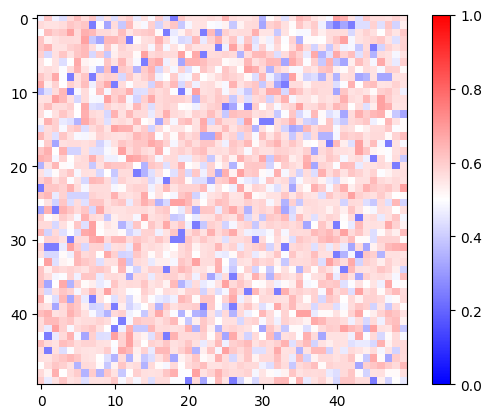

In [665]:
import matplotlib.pyplot as plt
import numpy as np

# Tu grid
grid = grid_heatmap

# Armar la matriz
max_i = max(i for (i, j) in grid.keys())
max_j = max(j for (i, j) in grid.keys())

matrix = np.zeros((max_i + 1, max_j + 1))

for (i, j), value in grid.items():
    matrix[i, j] = value

# Graficar el heatmap
plt.imshow(matrix, cmap='bwr', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.show()

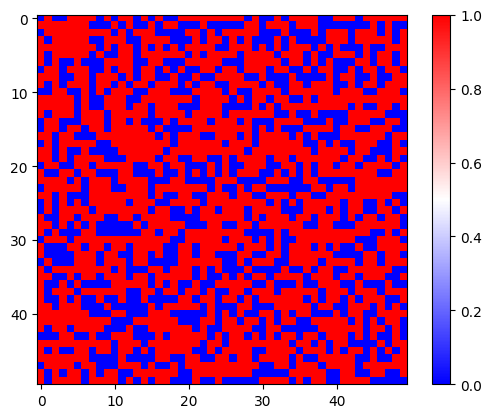

In [666]:
# Tu grid
grid = grid_classification

# Armar la matriz
max_i = max(i for (i, j) in grid.keys())
max_j = max(j for (i, j) in grid.keys())

matrix = np.zeros((max_i + 1, max_j + 1))

for (i, j), value in grid.items():
    matrix[i, j] = value

# Graficar el heatmap
plt.imshow(matrix, cmap='bwr', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.show()